<a href="https://colab.research.google.com/github/gimquokka/DACON_Jeju_credit_card_bigdata_competition/blob/master/CHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 제주 빅데이터 경진대회
#### 최해송
### Problem : 2020.04, 2020.07 기간 내 지역, 업종 별 월간 총 사용 금액 예측 
- 2019.01 ~ 2020.03 기간 내 카드 데이터, 201901-202003.csv (2.07 GB)
- 2020.04 기간 내 카드 데이터 (7/28 공개), 202004.csv (116 MB)
- 제출 양식, submission.csv (64 KB)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings("ignore")

### Variables 설명
- CARD_SIDO_NM : 카드이용지역_시도 (가맹점 주소 기준)
- CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
- STD_CLSS_NM : 업종명
- HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
- HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)
- AGE : 연령대
- SEX_CTGO_CD : 성별 (1: 남성, 2: 여성)
- FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
- CSTMR_CNT : 이용고객수 (명)
- AMT : 이용금액 (원)
- CNT : 이용건수 (건)

### Preprocessing

In [ ]:
card_df_org = pd.read_csv('../input/Dacon_credit_card/201901-202003.csv')
card_df = card_df_org.copy()
card_df.head(3)

REG_YYMM CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM HOM_CCG_NM  AGE  \
0    201901           강원         강릉시  건강보조식품 소매업          강원        강릉시  20s   
1    201901           강원         강릉시  건강보조식품 소매업          강원        강릉시  30s   
2    201901           강원         강릉시  건강보조식품 소매업          강원        강릉시  30s   

   SEX_CTGO_CD  FLC  CSTMR_CNT      AMT  CNT  
0            1    1          4   311200    4  
1            1    2          7  1374500    8  
2            2    2          6   818700    6

In [ ]:
print('The shape of dataset: ', card_df.shape)
print('Null_data: ', card_df.isnull().sum()[card_df.isnull().sum() > 0])

The shape of dataset:  (24697792, 12)
Null_data:  CARD_CCG_NM     87213
HOM_CCG_NM     147787
dtype: int64


- Null data: CARD_CCG_NM / HOM_CCG_NM 모두 object형

In [ ]:
card_df.info() #int and object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24697792 entries, 0 to 24697791
Data columns (total 12 columns):
REG_YYMM        int64
CARD_SIDO_NM    object
CARD_CCG_NM     object
STD_CLSS_NM     object
HOM_SIDO_NM     object
HOM_CCG_NM      object
AGE             object
SEX_CTGO_CD     int64
FLC             int64
CSTMR_CNT       int64
AMT             int64
CNT             int64
dtypes: int64(6), object(6)
memory usage: 2.2+ GB


### Preprocessing_Target y

In [ ]:
card_df['AMT'].groupby(card_df['STD_CLSS_NM']).describe()

count          mean  ...         75%           max
STD_CLSS_NM                                     ...                          
건강보조식품 소매업               83857.0  1.253639e+06  ...  1352000.00  1.657308e+08
골프장 운영업                 236554.0  2.518249e+06  ...  2336000.00  2.695825e+08
과실 및 채소 소매업             504479.0  1.226867e+06  ...   679000.00  1.702847e+08
관광 민예품 및 선물용품 소매업        78793.0  1.920146e+05  ...   200500.00  2.754680e+07
그외 기타 분류안된 오락관련 서비스업       288.0  1.293281e+05  ...   166250.00  4.625000e+05
그외 기타 스포츠시설 운영업          11077.0  2.466295e+05  ...   273500.00  1.934836e+07
그외 기타 종합 소매업            351817.0  2.915411e+06  ...  1620000.00  6.018907e+08
기타 대형 종합 소매업           1495163.0  4.901710e+06  ...  1362520.00  1.227249e+09
기타 수상오락 서비스업              6356.0  2.629498e+05  ...   300000.00  4.767000e+06
기타 외국식 음식점업             556813.0  1.119169e+06  ...   597700.00  1.170151e+08
기타 주점업                   73244.0  2.249380e+06  ...  1752525.00  3.447030e+08
기타음식료품위주종합소매업           558716.0  2.808666e+06  ...   815805.00  3.729463e+08
내항 여객 운송업                72294.0  5.811694e+05  ...   533900.00  9.126893e+07
마사지업                     17844.0  1.132027e+06  ...  1300000.00  2.106370e+07
면세점                     144349.0  2.802321e+06  ...  2824501.00  1.407692e+08
버스 운송업                  192281.0  1.197397e+06  ...  1264300.00  3.836500e+07
비알콜 음료점업               1586120.0  7.209403e+05  ...   311972.50  1.108716e+08
빵 및 과자류 소매업             989794.0  9.028057e+05  ...   325200.00  1.385468e+08
서양식 음식점업               1404839.0  1.244526e+06  ...   580450.00  2.413645e+08
수산물 소매업                 255488.0  1.162606e+06  ...   863700.00  1.142342e+08
슈퍼마켓                   1630700.0  4.127264e+06  ...   694041.00  1.473270e+09
스포츠 및 레크레이션 용품 임대업      466533.0  2.670176e+06  ...  1897000.00  3.293402e+08
여관업                     334994.0  7.728617e+05  ...   630000.00  1.045735e+08
여행사업                     47446.0  2.297700e+06  ...  2481035.00  9.306741e+07
욕탕업                     259567.0  7.323144e+05  ...   431500.00  4.753960e+07
육류 소매업                  327160.0  3.564125e+06  ...  1715502.50  3.862005e+08
일반유흥 주점업                174081.0  3.109559e+06  ...  2296700.00  4.188273e+08
일식 음식점업                 539071.0  1.469828e+06  ...   959175.00  1.820208e+08
자동차 임대업                  26024.0  1.090480e+06  ...  1486875.00  5.734022e+07
전시 및 행사 대행업             330569.0  3.161441e+05  ...   261000.00  7.557519e+07
정기 항공 운송업               115914.0  5.013188e+06  ...  4354100.00  3.371753e+08
중식 음식점업                 698803.0  1.362847e+06  ...   735700.00  1.693373e+08
차량용 가스 충전업              218242.0  1.086253e+06  ...   821257.50  8.818851e+07
차량용 주유소 운영업            1613476.0  4.777668e+06  ...  1592011.25  1.521805e+09
체인화 편의점                3210466.0  1.652084e+06  ...   527480.00  9.242094e+08
택시 운송업                  381993.0  4.537804e+06  ...  1816280.00  3.151316e+08
피자 햄버거 샌드위치 및 유사 음식점업  1351478.0  8.143538e+05  ...   312550.00  1.454642e+08
한식 음식점업                3697166.0  3.715681e+06  ...  1187000.00  2.349524e+09
호텔업                     155309.0  1.448856e+06  ...  1153900.00  4.421121e+08
화장품 및 방향제 소매업           383713.0  1.666298e+06  ...  1190060.00  1.168018e+08
휴양콘도 운영업                114921.0  6.951024e+05  ...   754800.00  3.381470e+08

[41 rows x 8 columns]

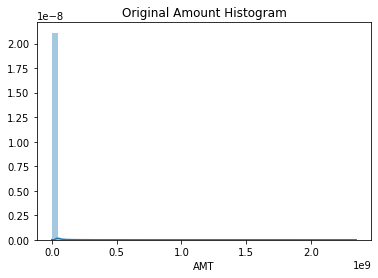

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Original Amount Histogram')
sns.distplot(card_df['AMT']) 
#Right-skewed distribution

#### Log Transformation of y

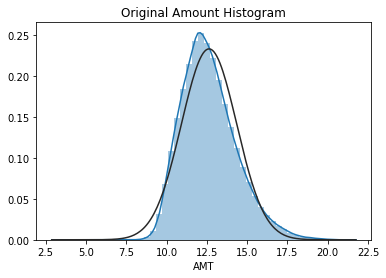

In [ ]:
#np.sort(card_df['AMT'])[::-1][:100]
log_AMT = np.log1p(card_df['AMT'])

card_df.insert(0,'log_AMT', log_AMT)
card_df.drop('AMT', axis=1 , inplace=True)

plt.figure(figsize=(6,4))
plt.title('Original Amount Histogram')
sns.distplot(log_AMT,fit=norm)

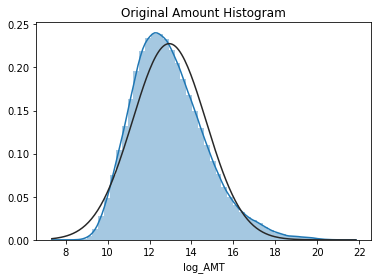

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Original Amount Histogram')
sns.distplot(card_df['log_AMT'][card_df['STD_CLSS_NM']=='한식 음식점업'],fit=norm)

### Preprocessing_Features

In [ ]:
# Year/Month
card_df['year'] = card_df['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
card_df['month'] = card_df['REG_YYMM'].apply(lambda x: int(str(x)[4:]))
card_df.drop('REG_YYMM', axis=1 , inplace=True)

- One-Hot Encoding 이용해서 dummies 만들어주려고 했으나, 시간 오래 걸림. Error 발생
- Label Encoding이용 : Linear Regression에서는 사용할 수 없음. Tree based ML 가능

In [ ]:
card_df.isnull().sum()
#CARD_CCG_NM      87213
#HOM_CCG_NM      147787
#CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
#HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)

CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
year                 0
month                0
dtype: int64

### Null이 나오게 된 이유 (Missing Not at Random)

In [ ]:
print(card_df.CARD_CCG_NM.value_counts())

중구     1185474
남구      512319
동구      509407
서구      501952
강서구     490111
        ...   
청양군      13894
신안군      10296
울릉군      10210
봉화군       9841
영양군       5728
Name: CARD_CCG_NM, Length: 226, dtype: int64


In [ ]:
# null_columns=card_df.columns[card_df.isnull().any()]
#print(card_df[card_df.isnull().any(axis=1)][null_columns].head())

card_df[card_df["HOM_CCG_NM"].isnull()]

log_AMT CARD_SIDO_NM CARD_CCG_NM  ... CNT  year month
420       10.968216           강원         강릉시  ...   3  2019     1
421       12.479913           강원         강릉시  ...   4  2019     1
1189      12.081308           강원         강릉시  ...   3  2019     1
1190      12.366834           강원         강릉시  ...   6  2019     1
1191      12.087520           강원         강릉시  ...   5  2019     1
...             ...          ...         ...  ...  ..   ...   ...
24697496  12.146859           충북         충주시  ...   8  2020     3
24697497  13.870473           충북         충주시  ...  28  2020     3
24697498  13.554342           충북         충주시  ...  35  2020     3
24697499   9.878221           충북         충주시  ...   4  2020     3
24697500  11.559819           충북         충주시  ...   6  2020     3

[147787 rows x 13 columns]

In [ ]:
print(card_df[card_df["HOM_CCG_NM"].isnull()].groupby(card_df['HOM_SIDO_NM']).describe())
print(card_df.HOM_SIDO_NM.value_counts())

            SEX_CTGO_CD                               ... month                     
                  count      mean      std  min  25%  ...   min  25%  50%  75%   max
HOM_SIDO_NM                                           ...                           
세종             147787.0  1.388539  0.48742  1.0  1.0  ...   1.0  2.0  5.0  9.0  12.0

[1 rows x 56 columns]
경기    6614016
서울    5387540
부산    1960951
경남    1463499
인천    1350921
대구    1077209
경북    1068082
충남     909568
전남     765499
전북     741515
충북     687090
광주     667626
강원     602004
대전     586938
울산     502297
제주     165250
세종     147787
Name: HOM_SIDO_NM, dtype: int64


- "Home_CCG_NM" NULL나오는 이유 : HOM_SIDO_NM(거주지역_시도 (고객 집주소 기준)) ==세종 인 경우.
- 그러면 세종의 몇 퍼센트가 Null값인가?  100% 세종 전체가 Null값이다.


In [ ]:
print(card_df[card_df["CARD_CCG_NM"].isnull()].groupby(card_df['CARD_SIDO_NM']).describe())
#print(card_df.HOM_SIDO_NM.value_counts())

              log_AMT                                 ... month                
                count       mean       std       min  ...   25%  50%  75%   max
CARD_SIDO_NM                                          ...                      
세종            87213.0  12.447373  1.674134  7.626083  ...   3.0  5.0  9.0  12.0

[1 rows x 56 columns]



- "CARD_CCG_NM" : 똑같이 모두 세종에서 나옴.
- Encoding하기전에 CARD_CCG_NM, HOM_CCG_NM를 지움 (이유 : Encoding에서 NaN값을 하나의 그룹으로 묶어버림) 그래서 Encoding 후에 null값이 사라짐.
- 따라서 Encoding 하기전에 NaN값을 처리해야함.
- 만약 이 2 columns를 지운다면? 거주지역_시도에 따른 (지역에 따른) 예측을 할 수 없음.


#### Null값을 어떻게 처리?
- 제거
- 평균은 추천하지 않음.
- 지인에게 물어본 바로는 R package에 mice를 사용한다고 함. 다른 features에 연관성을 찾아서 null값을 추측해 대입함.
- 그렇지만 우리의 Null 항목은 숫자데이터가 아닌 object data... 과연 다른 features들이 CARD_CCG_NM,HOME_CCG_NM에 연관성이 있나.

- 결론! : 세종은 세종특별자치시. 군이나 구가 존재하지 않는다.
- 서울시는 강서구, 중구...등으로 나눠져 있음.


- 시/구가 존재하지 않기 때문에 NA대신 데이콘시를 넣어 하나의 그룹을 만들어 줌.

In [ ]:
card_df["CARD_CCG_NM"].fillna("데이콘시", inplace=True)

In [ ]:
card_df["HOM_CCG_NM"].fillna("데이콘시", inplace=True)

In [ ]:
card_df.isnull().sum()

log_AMT         0
CARD_SIDO_NM    0
CARD_CCG_NM     0
STD_CLSS_NM     0
HOM_SIDO_NM     0
HOM_CCG_NM      0
AGE             0
SEX_CTGO_CD     0
FLC             0
CSTMR_CNT       0
CNT             0
year            0
month           0
dtype: int64

### Encoding

In [ ]:
columns = ['CARD_SIDO_NM','CARD_CCG_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM','HOM_CCG_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT', 'CNT', 'year', 'month']
card_df = card_df.groupby(columns).sum().reset_index(drop=False)
#24697792 ->

In [ ]:
print(card_df.head(10))
print(card_df.shape)

  CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM HOM_CCG_NM  AGE  \
0           강원         강릉시  건강보조식품 소매업          강원        강릉시  20s   
1           강원         강릉시  건강보조식품 소매업          강원        강릉시  20s   
2           강원         강릉시  건강보조식품 소매업          강원        강릉시  20s   
3           강원         강릉시  건강보조식품 소매업          강원        강릉시  20s   
4           강원         강릉시  건강보조식품 소매업          강원        강릉시  30s   
5           강원         강릉시  건강보조식품 소매업          강원        강릉시  30s   
6           강원         강릉시  건강보조식품 소매업          강원        강릉시  30s   
7           강원         강릉시  건강보조식품 소매업          강원        강릉시  30s   
8           강원         강릉시  건강보조식품 소매업          강원        강릉시  30s   
9           강원         강릉시  건강보조식품 소매업          강원        강릉시  30s   

   SEX_CTGO_CD  FLC  CSTMR_CNT  CNT  year  month    log_AMT  
0            1    1          4    4  2019      1  12.648194  
1            1    1          7    9  2019     11  13.420245  
2            2    1          3    3  2020  

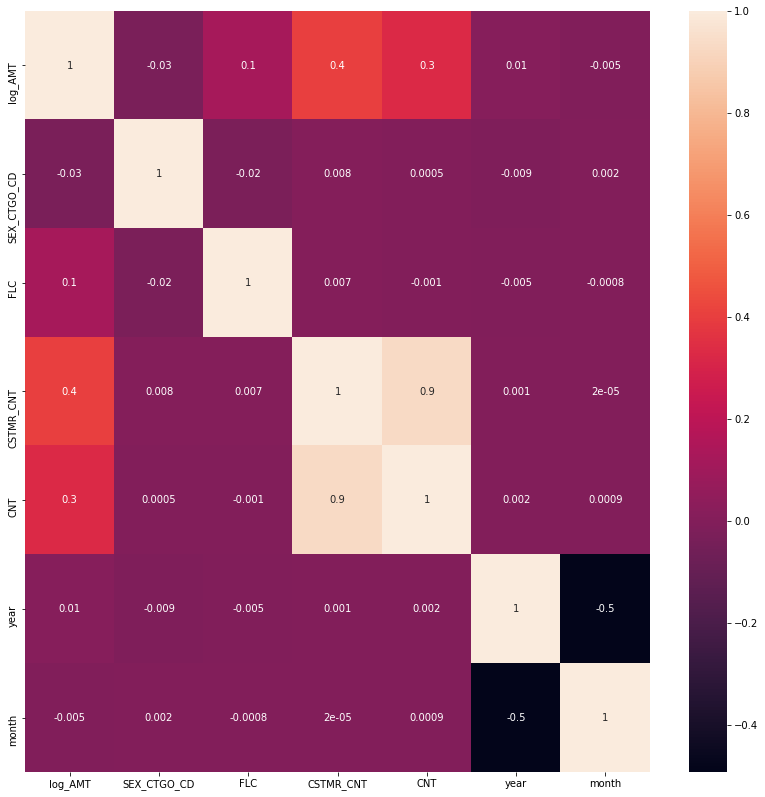

In [ ]:
corr = card_df.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.1g')

In [ ]:
# 인코딩
dtypes = card_df.dtypes
encoders = {}
for column in card_df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(card_df[column])
        encoders[column] = encoder
        
df_num = card_df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(card_df[column])

In [ ]:
train_num = df_num.sample(frac=1, random_state=0)
#frac=1 전체를 randomly 추출
#df.sample(frac = 0.5) -> frac은 특정 비율로 데이터를 랜덤하게 샘플링 해옴
#이걸 왜 하는 것인가...????
print(train_num.shape)
print(train_num.head(10))

(24697792, 13)
          CARD_SIDO_NM  CARD_CCG_NM  STD_CLSS_NM  HOM_SIDO_NM  HOM_CCG_NM  \
10571221             7            5           11            7          83   
9936968              5          178           16            5          90   
4953046              1          144           36            8         125   
2132537              1           37            9            1         119   
2339879              1           49            1            8          52   
14253489             8           32            9            8          29   
6139118              1          213           20            3         115   
467278               0          123           34            1         223   
24445961            16          199           34           16         180   
24320285            16          198           27           16         198   

          AGE  SEX_CTGO_CD  FLC  CSTMR_CNT  CNT  year  month    log_AMT  
10571221    3            2    3          4   19  2019     12  1

### After Encoding, log transformation of  X_features
- Encoding한 뒤, X_features transformation 중 sknewness value가 큰 것은 log transformation을 시킴

In [ ]:
X_features = train_num.drop('log_AMT',axis=1)

skew_features = X_features.apply(lambda x: skew(x))
skew_features_top = skew_features[skew_features > 2]
skew_features[skew_features > 2]

#CSTMR_CNT : 이용고객수 (명)
#CNT : 이용건수 (건)

CSTMR_CNT    20.721998
CNT          28.453581
dtype: float64

In [ ]:
X_features[skew_features_top.index] = np.log1p(X_features[skew_features_top.index])

In [ ]:
X_features.apply(lambda x: skew(x))

CARD_SIDO_NM    0.299641
CARD_CCG_NM     0.120707
STD_CLSS_NM    -0.486137
HOM_SIDO_NM     0.444385
HOM_CCG_NM      0.260868
AGE             0.293240
SEX_CTGO_CD     0.354879
FLC             0.163514
CSTMR_CNT       1.450614
CNT             1.300400
year            1.729155
month           0.249875
dtype: float64

### Correlation between X_features/ Correlation between X and Y

In [ ]:
X_features['log_AMT'] = train_num.log_AMT

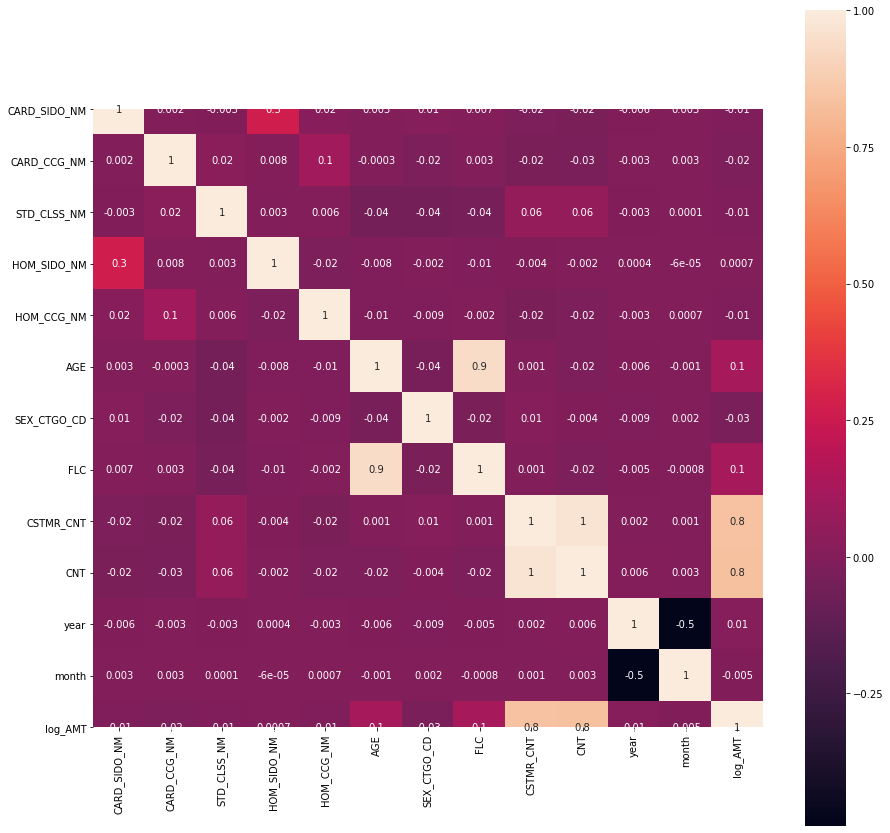

In [ ]:
corr= X_features.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.1g',square=True)

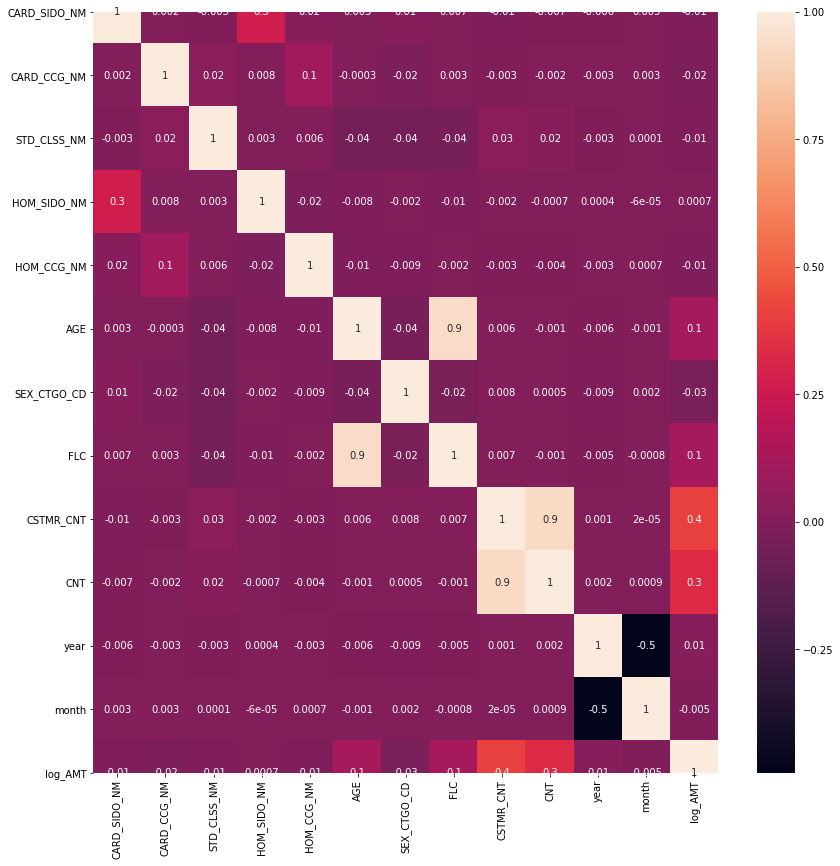

In [ ]:
corr= train_num.corr()
plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, fmt='.1g')

### Dimension Reduction
- Feature Selection(피처선택) : CSTMR_CNT와 CNT가 상관관계 매우 높음 (0.9) 둘 중에 하나 선택. FLC와 Age가 상관관계 높음 0.9 둘 중에 하나 선택
- Feature Extraction(피처추출) : Nominal(Catergorical) Data는 pca를 사용하지 않음.
https://stats.libretexts.org/Bookshelves/Computing_and_Modeling/RTG%3A_Classification_Methods/4%3A_Numerical_Experiments_and_Real_Data_Analysis/Preprocessing_of_categorical_predictors_in_SVM%2C_KNN_and_KDC_(contributed_by_Xi_Cheng)
- Dummy variables를 만든 다음에 svm이라던지 사용할 수 있음.

### Outlier 제거

- - -
#### X features, X_test, y_train, y_test